. 

<font size=7>Opto Closed Loop Experiment Template

In this notebook we create the protocol for the opto close looop experiment. Make a copy of this template and the change the parameters to set up your specific experiment.

<font color="red"> **Before you run code** - Set key experiment variables below

**Experiment Summary**
The code and runtime results for everysingle experiment is provided inside of this notebook.

* experiment-0: test opto intensity sweep, observed 10s light on, 20s light off
* experiment-1: green light 10s on 30s off
* experiment-2: seizure-bic closed loop



In [14]:
#maxwell_config = "/home/mxwbio/work/seizure_closed_loop/files/maxwell/configs/????????????.cfg"
maxwell_config = "/home/mxwbio/work/seizure_closed_loop/files/maxwell/configs/Hc627_JA-KV-test_070323.cfg" # Debug Code
arduino_path="/dev/ttyACM1"

In [3]:
#experiment_name = "???????????????"
experiment_name = "Hc627_hckcr1_A_070423" # Debug Code

# <font color="gray"> Set Up Notebook

Import required packages

In [4]:
import MaxwellGI as mgi
import time
import numpy as np
import matplotlib.pyplot as plt

## <font color="blue"> countSpikes

<font color="blue">countSpikes</font> is a function that counts the number of spikes that occure. Spike are counted over some set window of time, `count_window_seconds`. Spikes are continually counted throughout the duration of the experiment, `experiment_length_seconds`. All the spike counts that were recorded are then returned to the user.

In [5]:
def countSpikes( experiment_length_seconds, count_window_seconds=10 ):
    print("starting devices")
    maxwell = mgi.MaxwellCtl( config= maxwell_config )          # Turn Maxwell On
    stream  = mgi.Streamer( maxwell, filtered=False )           # Start Livestream
    
    print("Starting experiment")
    experiment_end = time.time() + experiment_length_seconds                                  
    first_time = True
    spike_counts = []
    while time.time() < experiment_end:                                  # while the experiment hasn't reached it's final run length
        count_time = time.time() + count_window_seconds                  # Count spikes over the count window length
        spike_count = 0                                                  # continually add new spikes to spike_count
        
        while time.time() < count_time:                                  # for our specified count winow length
            frameID, voltages, spikes = stream.getData()                 # get spikes data
            for spike in spikes:                                         # add up all of the spikes to spike_count
                spike_count += 1
        print("Spike Count: ", spike_count )    
        if not first_time:                                              # We don't record the first spike count, because that value is often wonky
            spike_counts.append(spike_count)                            # but we record the rest of the spike counts
        first_time = False

    
    print("Experiment over. Shutting down devices")
    del stream                # Stop Stream
    print("done")
    return spike_counts

## <font color="blue">optoRecording

In [6]:
def optoRecording( light_on_seconds, light_off_seconds, num_pulses, light_intensity,
                       calibration_file, data_file, log_file ):
    
    maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
    opto_ctl = mgi.OptoCtl( log_file=log_file , 
                       calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
    maxwell.recordingStart( data_file=data_file)                                           # Start recording data             

    print("Starting experiments")
    time.sleep(20)
    print("Light On")
    opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=light_off_seconds*1000, num_pulses=num_pulses, intensity=light_intensity)
    print("Light Off")
    time.sleep(60)

    # Shut Down Experiment
    print("shutting down devices")
    opto_ctl.close()          # Stop Opto
    maxwell.recordingStop()  # stop recording
    print("done")


## <font color="blue"> optoIntensitySweep

In [7]:
def optoIntensitySweep( light_on_seconds, calibration_file, data_file, log_file ):

    maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
    opto_ctl = mgi.OptoCtl( log_file=log_file , 
                       calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
    maxwell.recordingStart( data_file=data_file)                                           # Start recording data             

    print("Starting experiments")
    time.sleep(20)
    for light in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
        print("Intensity: ",light)
        print("Light On")
        opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=100, num_pulses=1, intensity=light)
        print("Light Off")
        time.sleep(30)
    time.sleep(20)
    
    # Shut Down Experiment
    print("Experiment finished. shutting down devices")
    opto_ctl.close()          # Stop Opto
    maxwell.recordingStop()  # stop recording
    print("done")
    
    

## <font color="blue">optoClosedLoop 

First time had  bicuculine, but didn't not reach threshold

Second time, left out wait time at begining, reached threshold once

3rd time, had wait time added biculuine

In [22]:
def optoClosedLoop( experiment_length_seconds, count_window_seconds, spike_threshold, light_on_seconds, light_intensity,
                    calibration_file, data_file, log_file  ):
    
    ### Set up Maxwell and Opto
    maxwell = mgi.MaxwellCtl( config=maxwell_config)                                       # Turn Maxwell On
    stream  = mgi.Streamer( maxwell, filtered=False )                                      # Start Livestream
    opto_ctl = mgi.OptoCtl( log_file=log_file , 
                       calibration_file=calibration_file, arduino_path=arduino_path)       # Set up Opto
    maxwell.recordingStart( data_file=data_file)                                           # Start recording data                
    
    time.sleep(30)
    print("ADD BICUCULINE")
    time.sleep(20)
    
    # Define Closed Loop Experiment
    print("Starting closed loop")
    last_opto = 0
    skip_count_check = True
    spike_counts=[]
    experiment_end = time.time() + experiment_length_seconds             # End the experiment in 20 seconds
    while time.time() < experiment_end:                                  # while the experiment hasn't run for 20 seconds
        count_time = time.time() + count_window_seconds                  # Count spikes over 1 second window
        spike_count = 0                                                  # continually add new spikes to spike_count
        while time.time() < count_time:                                  # while still in 1 second window
            frameID, voltages, spikes = stream.getData()                 # get spikes data
            for spike in spikes:                                         # if there's a spike add it to the spike_count
                spike_count += 1
        print("Spike Count: ", spike_count )    
        spike_counts.append(spike_count) 
    
        if spike_count > spike_threshold and not skip_count_check :           # If tehre are more than 10 spikes in a second
            print("Starting Opto Pulses")                                              # Do some opto pulses
            opto_ctl.pulses(  on_duration=light_on_seconds*1000, off_duration=10000, num_pulses=1, intensity=light_intensity ) #hanged off-duration from 100 to 10000
            print("finished pulses")
            #skip_count_check =True
            #print("emptying artifact spikes")
            #frameID, voltages, spikes = stream.getData() 
            #last_opto = time.time()
            #empty_time = time.time()+10                                  # wait 10 second to empty out previous data from stream
            #while time.time() < empty_time:
            #    stream.getData()                                         # Empty out stream data, because pulses created many fake spikes
            #print("finished emptying")
            #else:
        skip_count_check = False
        
    print("experiment finished")    
    time.sleep(60)                                                      # post light recording
    
    # Shut Down Experiment
    print("shutting down devices")
    del stream                # Stop Stream
    opto_ctl.close()          # Stop Opto
    maxwell.recordingStop()  # stop recording
    print("done")
    return spike_counts

# <font color="purple"> Experiment: Opto Intensity Sweep <font color="green"> - Green

## <font color="purple">Run Experiment <font color="green">

In [16]:
optoIntensitySweep( light_on_seconds=10,
                    log_file= f"./files/opto/logs/{experiment_name}_0",
                    calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                    data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_0.h5" )

MaxOne initialized
Available USB devices:
('ASRL/dev/ttyACM1::INSTR',)
recording_filename 20230703T145615-Hc627_JA-KV-test_070323_0
stim_log_file: ./files/opto/logs/20230703T145615-Hc627_JA-KV-test_070323_0_opto_stim_log.csv
CSV file is 0
Recording Started
Starting experiments
Intensity:  0.1
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.1 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.2
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.2 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.3
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.3 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.4
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.4 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.5
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
Light Off
Intensity:  0.6
Light On
Stim pulse 	 use_maxwell: T

## Second Experiment <font color="red">red

In [ ]:
optoIntensitySweep( light_on_seconds=10,
                    log_file= f"./files/opto/logs/{experiment_name}_11",
                    calibration_file= "./files/opto/calibrations/20230203T152939-ucsf-opto-system-a_real-625nm-1a-v1.csv",
                    data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_11.h5" )

## Thrid Experiment <font color="blue"> Blue

In [ ]:
optoIntensitySweep( light_on_seconds=10,
                    log_file= f"./files/opto/logs/{experiment_name}_12",
                    calibration_file= "./files/opto/calibrations/20230203T153451-ucsf-opto-system-b_real-470nm-1a-v1.csv",
                    data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_12.h5" )

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - text about what you did


# <font color="purple"> Experiment: Opto <font color="green">Green</font> Light

## <font color="purple">Run Experiment

In [17]:
optoRecording( light_on_seconds=10, light_off_seconds=30, num_pulses=5, light_intensity=.5, #int("?????????"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_1.h5",
                log_file = f"./files/opto/logs/{experiment_name}_1")

MaxOne initialized
Available USB devices:
('ASRL/dev/ttyACM1::INSTR',)
recording_filename 20230703T150702-Hc627_JA-KV-test_070323_1
stim_log_file: ./files/opto/logs/20230703T150702-Hc627_JA-KV-test_070323_1_opto_stim_log.csv
CSV file is 0
Recording Started
Starting experiments
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Light Off
shutting down devices
Recording finished
done


## Second Epxeriment

In [11]:
optoRecording( light_on_seconds=10, light_off_seconds=30, num_pulses=5, light_intensity=.5, #int("?????????"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_10.h5",
                log_file = f"./files/opto/logs/{experiment_name}_10")

MaxOne initialized
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230509T175903-hc52_18763_rec05092023_10
stim_log_file: ./files/opto/logs/20230509T175903-hc52_18763_rec05092023_10_opto_stim_log.csv
CSV file is 0
Recording Started
Starting experiments
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 600000
Light Off
shutting down devices
Recording finished
done


## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - {number}hz {color} light pulse, with {numbers} second pause in between
    * calibration file - ?
    * recording file - ?

# <font color="purple"> Experiment: Opto <font color="red">Red</font> Light

## <font color="purple">Run Experiment

In [18]:
optoRecording( light_on_seconds=10, light_off_seconds=3, num_pulses=1, light_intensity=.5, #int("???????"),
                calibration_file= "./files/opto/calibrations/20230203T152939-ucsf-opto-system-a_real-625nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_7.h5",
                log_file = f"./files/opto/logs/{experiment_name}_7")

MaxOne initialized
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230509T174837-hc52_18763_rec05092023_7
stim_log_file: ./files/opto/logs/20230509T174837-hc52_18763_rec05092023_7_opto_stim_log.csv
CSV file is 0
Recording Started
Starting experiments
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 60000
Light Off
shutting down devices
Recording finished
done


## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - {number}hz {color} light pulse, with {numbers} second pause in between
    * calibration file - ?
    * recording file - ?

# <font color="purple"> Experiment: Opto <font color="blue">Blue</font> Light

## <font color="purple">Run Experiment

In [19]:
optoRecording( light_on_seconds=10, light_off_seconds=3, num_pulses=1, light_intensity=.5, #int("????????"),
                calibration_file= "./files/opto/calibrations/20230203T153451-ucsf-opto-system-b_real-470nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_8.h5",
                log_file = f"./files/opto/logs/{experiment_name}_8")

MaxOne initialized
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230509T175130-hc52_18763_rec05092023_8
stim_log_file: ./files/opto/logs/20230509T175130-hc52_18763_rec05092023_8_opto_stim_log.csv
CSV file is 0
Recording Started
Starting experiments
Light On
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 60000
Light Off
shutting down devices
Recording finished
done


## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name - {number}hz {color} light pulse, with {numbers} second pause in between
    * calibration file - ?
    * recording file - ?

# <font color="purple"> Experiment: Count Spikes

## First Closed Loop

### <font color="purple">Run Experiment

First spike count

In [18]:
spike_counts = countSpikes(60)

starting devices
MaxOne initialized
maxwell streamer ready
Starting experiment
Spike Count:  43
Spike Count:  56
Spike Count:  65
Spike Count:  54
Spike Count:  73
Spike Count:  64
Experiment over. Shutting down devices
done


Second spike count

In [14]:
spike_counts = countSpikes(60)

starting devices
MaxOne initialized
maxwell streamer ready
Starting experiment
Spike Count:  639
Spike Count:  703
Spike Count:  576
Spike Count:  647
Spike Count:  593
Spike Count:  750
Experiment over. Shutting down devices
done


THrid couns

In [16]:
spike_counts = countSpikes(60)

starting devices
MaxOne initialized
maxwell streamer ready
Starting experiment
Spike Count:  2177
Spike Count:  2771
Spike Count:  2840
Spike Count:  2852
Spike Count:  2974
Spike Count:  2960
Experiment over. Shutting down devices
done


### <font color="purple">Analyze Results

Plot histogram of spikes

Mean Spikes:  62.4


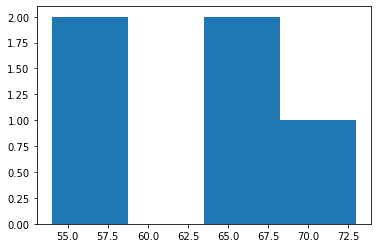

In [19]:
print("Mean Spikes: ", np.mean(spike_counts) )
plt.hist(spike_counts, bins='auto')  # arguments are passed to np.histogram
plt.show()

Save Data

In [20]:
np.savetxt( experiment_name+"_first_calibrate_spike_counts.csv", spike_counts, delimiter="," )
#checkit = np.loadtxt("some_experiment_spike_counts.csv")   # How to load data

## Second Closed Loop

### Count spikes

In [15]:
spike_counts = countSpikes(40)

starting devices
MaxOne initialized
maxwell streamer ready
Starting experiment
Spike Count:  49
Spike Count:  62
Spike Count:  80
Spike Count:  63
Experiment over. Shutting down devices
done


In [16]:
spike_counts = countSpikes(60)

starting devices
MaxOne initialized
maxwell streamer ready
Starting experiment
Spike Count:  52
Spike Count:  54
Spike Count:  68
Spike Count:  69
Spike Count:  58
Spike Count:  62
Experiment over. Shutting down devices
done


In [ ]:
print("Mean Spikes: ", np.mean(spike_counts) )
plt.hist(spike_counts, bins='auto')  # arguments are passed to np.histogram
plt.show()

### Closed loop

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment 1 - text about what you did
    * experiment_length_seconds=?, count_window_seconds=?, csv_file=?

# <font color="purple"> Experiment: Opto Closed Loop - <font color="green"> Bicuculine 

## <font color="purple">Run Experiment

<font color="red"><b>IMportant</b> how long do you want to record after light stim

Run experiment

First Epxerimet closed loop

In [23]:
spike_counts = optoClosedLoop( experiment_length_seconds= 90,
                count_window_seconds=10,
                spike_threshold= 25, #int("???"),
                light_on_seconds= 10,
                light_intensity= .5, #int("???"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_2.h5",
                log_file=  f"./files/opto/logs/{experiment_name}_2" )

MaxOne initialized
maxwell streamer ready
Available USB devices:
('ASRL/dev/ttyACM1::INSTR',)
recording_filename 20230703T160220-Hc627_JA-KV-test_070323_2
stim_log_file: ./files/opto/logs/20230703T160220-Hc627_JA-KV-test_070323_2_opto_stim_log.csv
CSV file is 0
Recording Started
ADD BICUCULINE
Starting closed loop
Spike Count:  413
Spike Count:  82
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 200000
finished pulses
Spike Count:  479
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 200000
finished pulses
Spike Count:  1309
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 200000
finished pulses
Spike Count:  1273
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 200000
finished pulses
Spike Count:  1262
Starting Opto Pulses
S

Second experiment closed loop

In [15]:
spike_counts = optoClosedLoop( experiment_length_seconds= 90,
                count_window_seconds=10,
                spike_threshold= 550, #int("???"),
                light_on_seconds= 10,
                light_intensity= .5, #int("???"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_2.h5",
                log_file=  f"./files/opto/logs/{experiment_name}_2" )

MaxOne initialized
maxwell streamer ready
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230510T145610-hc52_chip18790_rec51023_2
stim_log_file: ./files/opto/logs/20230510T145610-hc52_chip18790_rec51023_2_opto_stim_log.csv
CSV file is 0
Recording Started
ADD BICUCULINE
Starting closed loop
Spike Count:  7203
Spike Count:  1155
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  169
Spike Count:  913
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  178
Spike Count:  1206
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  352
Spike Count:  1354
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finishe

In [17]:
spike_counts = optoClosedLoop( experiment_length_seconds= 90,
                count_window_seconds=10,
                spike_threshold= 2500, #int("???"),
                light_on_seconds= 10,
                light_intensity= .5, #int("???"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_3.h5",
                log_file=  f"./files/opto/logs/{experiment_name}_3" )

MaxOne initialized
maxwell streamer ready
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230510T150239-hc52_chip18790_rec51023_3
stim_log_file: ./files/opto/logs/20230510T150239-hc52_chip18790_rec51023_3_opto_stim_log.csv
CSV file is 0
Recording Started
ADD BICUCULINE
Starting closed loop
Spike Count:  10952
Spike Count:  2437
Spike Count:  2145
Spike Count:  2407
Spike Count:  3023
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  1487
Spike Count:  2849
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
Spike Count:  1530
Spike Count:  2720
Starting Opto Pulses
Stim pulse 	 use_maxwell: True 	 arduino_intensity: 0.5 	 delay/on/off (frames): 0 / 200000 / 2000
finished pulses
experiment finished
shutting down devices
Recording finished
done


## Closed loop third

In [18]:
spike_counts = optoClosedLoop( experiment_length_seconds= 90,
                count_window_seconds=10,
                spike_threshold= 100, #int("???"),
                light_on_seconds= 10,
                light_intensity= .5, #int("???"),
                calibration_file= "./files/opto/calibrations/20230308T140514-ucsf-opto-system-b_real-530nm-1a-v1.csv",
                data_file= f" /home/mxwbio/work/seizure_closed_loop/files/maxwell/recordings/{experiment_name}_13.h5",
                log_file=  f"./files/opto/logs/{experiment_name}_13" )

MaxOne initialized
maxwell streamer ready
Available USB devices:
('ASRL/dev/ttyACM10::INSTR',)
recording_filename 20230509T182503-hc52_18763_rec05092023_13
stim_log_file: ./files/opto/logs/20230509T182503-hc52_18763_rec05092023_13_opto_stim_log.csv
CSV file is 0
Recording Started
ADD BICUCULINE
Starting closed loop
Spike Count:  578
Spike Count:  59
Spike Count:  53
Spike Count:  60
Spike Count:  58
Spike Count:  66
Spike Count:  66
Spike Count:  45
Spike Count:  64
experiment finished
shutting down devices
Recording finished
done


## <font color="purple">Document experiment

Save spike counts

In [ ]:
np.savetxt( experiment_name+"_no_bicuculine_spike_counts.csv", spike_counts, delimiter="," )

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment 1 - text about what you did
    * experiment_length_seconds=?, count_window_seconds=?, csv_file=?

## <font color="purple">Document experiment

<font color="red">Use the markdown below to document your experiment

**Experiments**

* Experiment_name -

# <font color="gray"> Additional Experiment Notes

Please put any additional experiment notes here